In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent / "src"))
sys.path.insert(0, str(Path.cwd().parent / "data"))

from torch.utils.data import DataLoader
from pathlib import Path

from visualize import show_lulc, show_rgb
from utils import process

/dss/dsshome1/07/di54rur/.conda/mamba/envs/zeroflood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
split = 'val'
root = '/dss/dsstbyfs02/scratch/07/di54rur/zeroflood'
max_samples = 3

process(split,root,max_samples,True,True)

[2026-01-30 18:42:16] Data Processing Start! TerraMesh - val


/dss/dsshome1/07/di54rur/.conda/mamba/envs/zeroflood/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:288: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


[2026-01-30 18:42:17] 0/0 samples processed.
Skipping... majortom_val_0000227 - Low IoU with water mask: 0.19901262544512788 < 0.5
Skipping... majortom_val_0000581 - Low IoU with water mask: 0.01398062527520916 < 0.5
torch.Size([2, 264, 264])
torch.Size([12, 264, 264])
torch.Size([3, 264, 264])
torch.Size([1, 264, 264])
(1, 264, 264)
[2026-01-30 18:42:43] 1/1000 samples processed.
Skipping... majortom_val_0000993 - Low IoU with water mask: 0.0 < 0.5
Skipping... majortom_val_0001045 - Low IoU with water mask: 0.0 < 0.5
torch.Size([2, 264, 264])
torch.Size([12, 264, 264])
torch.Size([3, 264, 264])
torch.Size([1, 264, 264])
(1, 264, 264)
Skipping... majortom_val_0001155 - Low IoU with water mask: 0.0 < 0.5
Skipping... majortom_val_0001446 - Low IoU with water mask: 0.0 < 0.5
Skipping... majortom_val_0001518 - Low IoU with water mask: 0.0 < 0.5
torch.Size([2, 264, 264])
torch.Size([12, 264, 264])
torch.Size([3, 264, 264])
torch.Size([1, 264, 264])
(1, 264, 264)


True

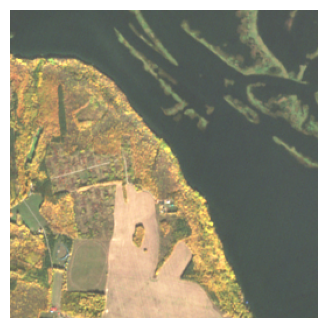

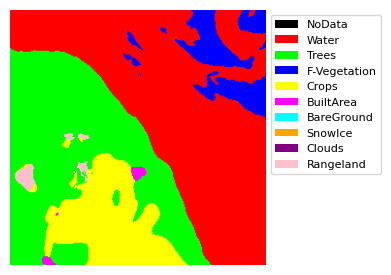

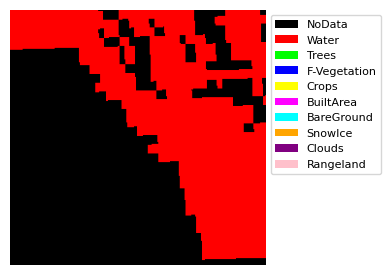

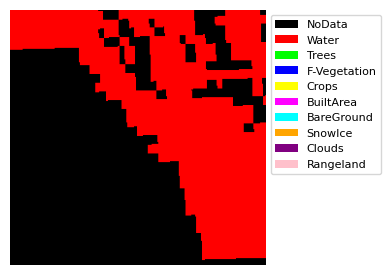

+++++++++++++++++++++++++++++++++


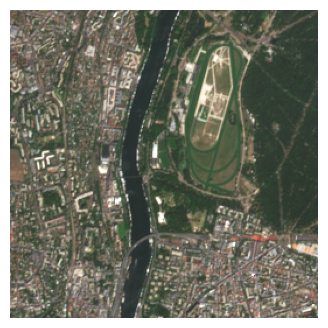

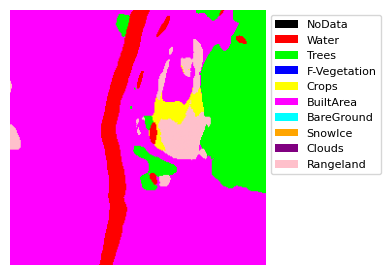

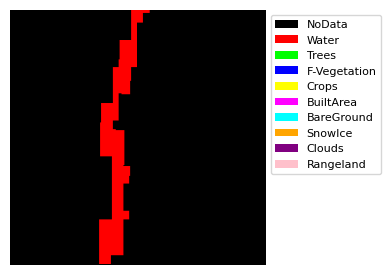

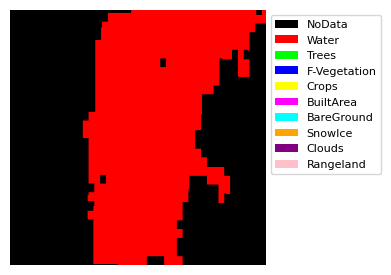

+++++++++++++++++++++++++++++++++


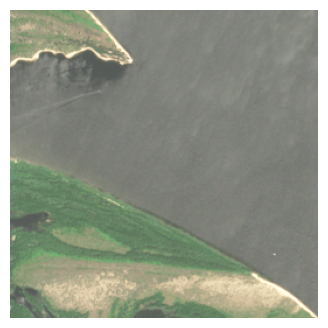

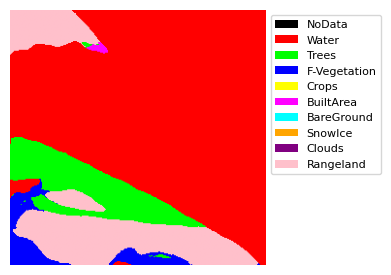

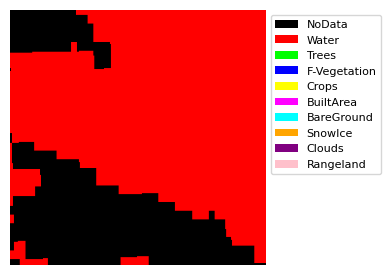

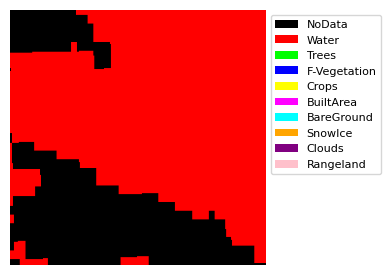

+++++++++++++++++++++++++++++++++


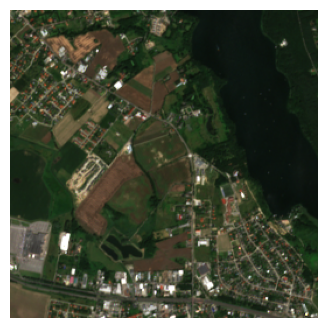

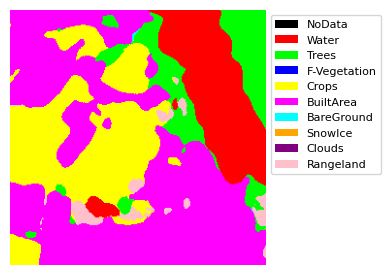

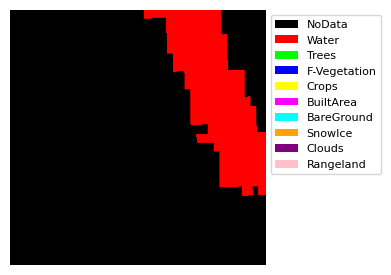

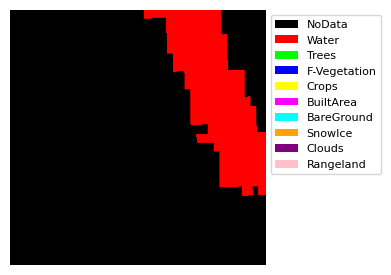

+++++++++++++++++++++++++++++++++


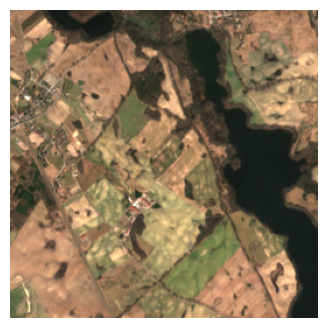

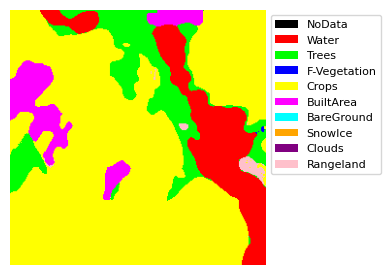

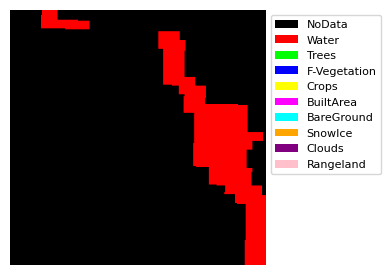

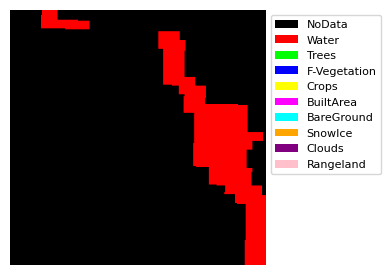

+++++++++++++++++++++++++++++++++


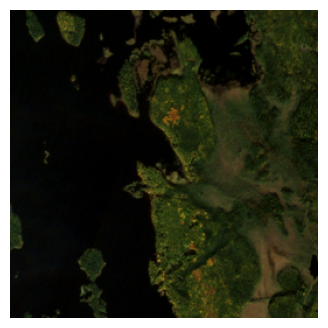

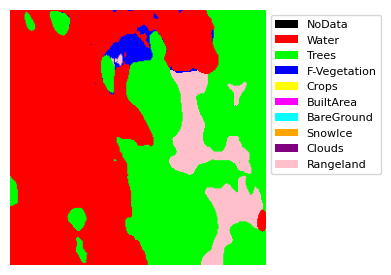

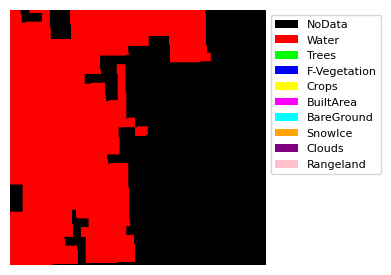

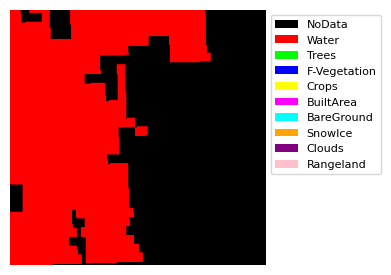

+++++++++++++++++++++++++++++++++


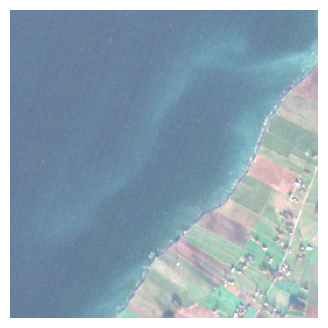

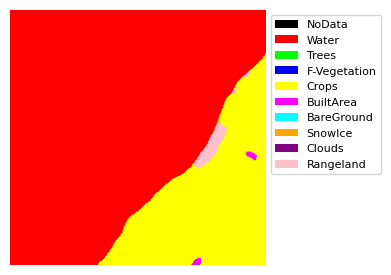

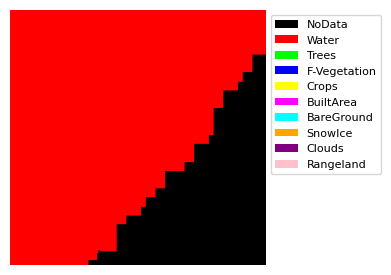

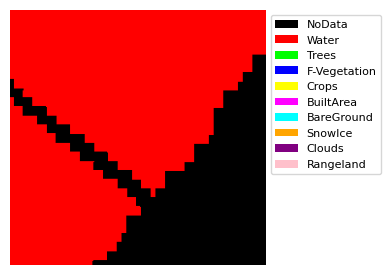

+++++++++++++++++++++++++++++++++


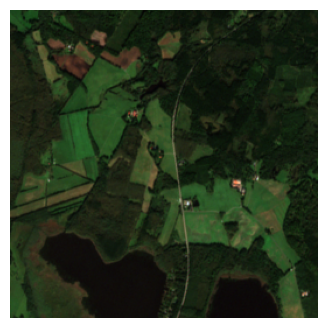

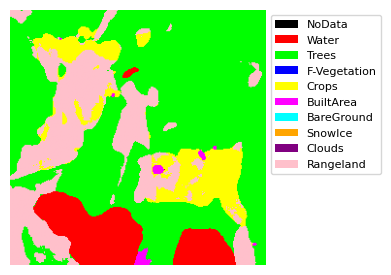

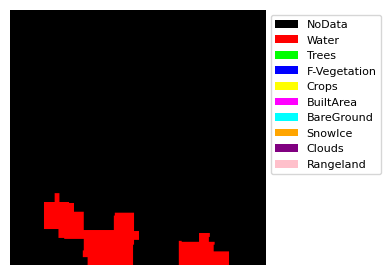

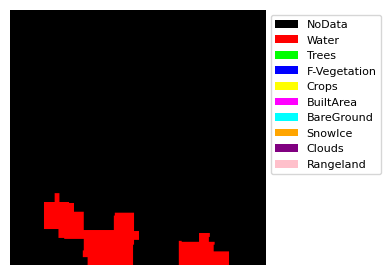

+++++++++++++++++++++++++++++++++


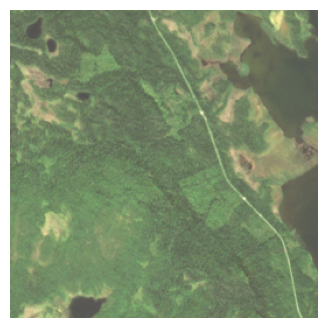

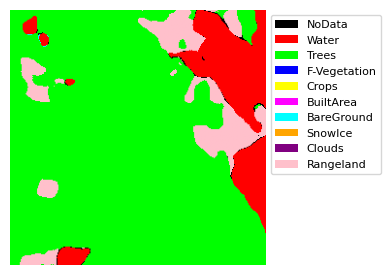

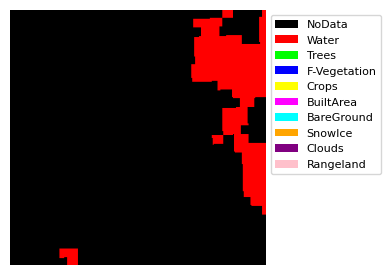

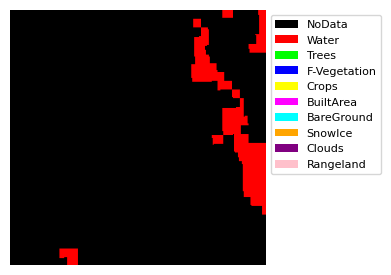

+++++++++++++++++++++++++++++++++


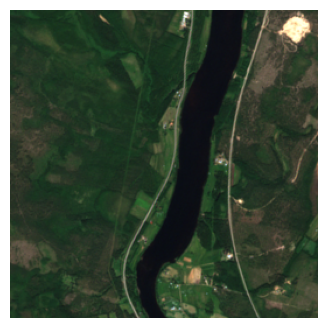

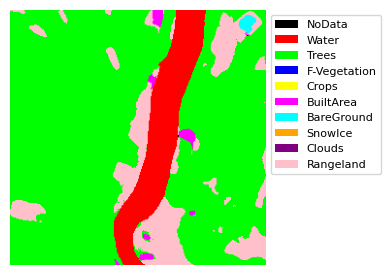

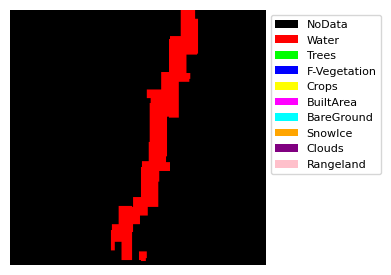

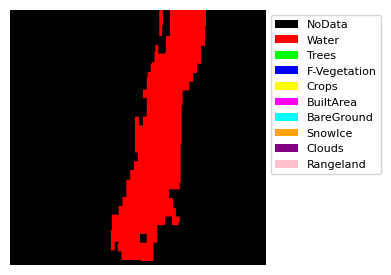

+++++++++++++++++++++++++++++++++


In [27]:
import torch
for i in range(max_samples):
    show_rgb(data_RGB[i])
    show_lulc(data_LULC[i])
    show_lulc(torch.Tensor(data_water[i]))
    show_lulc(torch.Tensor(data_flood[i]))
    print("+++++++++++++++++++++++++++++++++")

# Get Mask

In [ ]:
for idx in range(len(infos)):

    info = infos[idx]

In [ ]:
from pyproj import CRS
from affine import Affine
import torch


for idx in range(len(infos)):

    info = infos[idx]

    aoi_crs = CRS.from_epsg(info['spatial_ref']['EPSG'])  # example UTM zone
    aoi_shape = (264, 264)
    pixel_size = 10.0

    x0_center =  info['spatial_ref']['x0_y0'][0]
    y0_center =  info['spatial_ref']['x0_y0'][1]

    x_ul = x0_center - pixel_size / 2
    y_ul = y0_center + pixel_size / 2

    print(f"{info['keys']}\n{info['spatial_ref']['lon_lat']}")

    aoi_transform = Affine(
        pixel_size, 0, x_ul,
        0, -pixel_size, y_ul
    )

    has_flood, flood_mask = extract_mask(
        "/dss/dsstbyfs02/scratch/07/di54rur/zeroflood/LISFLOOD/flood_hazard/Europe_RP10_filled_depth.tif",
        aoi_transform,
        aoi_crs,
        aoi_shape,
    )

    has_water, water_mask = extract_mask(
        "/dss/dsstbyfs02/scratch/07/di54rur/zeroflood/LISFLOOD/flood_hazard/Europe_permanent_water_bodies.tif",
        aoi_transform,
        aoi_crs,
        aoi_shape,
    )

    if has_flood:
        print("Flood pixels detected:", flood_mask.sum())
    else:
        print("No flood overlap")

    if has_water:
        print("Water pixels detected:", water_mask.sum())
    else:
        print("No water overlap")

    show_rgb(data_RGB[idx])
    show_lulc(data_LULC[idx])
    if has_flood:
        show_lulc(torch.Tensor(flood_mask))
    if has_water:
        show_lulc(torch.Tensor(water_mask))
    
    print("==============================\n")

# Visualize

In [ ]:
for info in infos:
    RGB, LULC = info['lulc_ref']['data']
    show_rgb(RGB)
    show_lulc(LULC)